# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [13]:
########### Basic Parameters for Running: ################################
    
Version = "7.2.1-Small-Diego"                      # Used for tflite Filename
Testing_Percentage = 0.2                # 0.0 = Use all Images for Training
Training_Percentage = 0.2              # 0.0 = Use all Images for Training
Epoch_Anz = 200

##########################################################################


import tensorflow as tf
import autokeras as ak
import matplotlib.pyplot as plt
import glob
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, auc, cohen_kappa_score, classification_report
from tensorflow.keras.callbacks import History, EarlyStopping
from tensorflow.keras.utils import to_categorical
from PIL import Image

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

#### Importing useful functions
Useful functions to use in the notebook:
* generator_ti_array: given a list of tuples with data aumentation, tranform it to and array of X's values or y's values
* plot_confusion_matrix: given a sklearn confusion matrix (cm), make a nice plot.

In [21]:
def generator_to_array(generator,
                       X):
    """
    given a list of tuples with data aumentation, tranform it to and array of X's values or y's values

    Arguments
    ---------
    generator:    generator from tf.keras.preprocessing.image.ImageDataGenerator.flow

    X:            boolean. If True, extract the X's values.
                           If False, extract the y's values.
    """
    if X:
        array = generator[0][0]
        for i in range(1, len(generator)):
            array = np.append(array, generator[i][0], axis=0)
    else:
        array = generator[0][1]
        for i in range(1, len(generator)):
            array = np.append(array, generator[i][1], axis=0)
    return array

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          file_name='Confusion matrix'):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(file_name + '.png')
    plt.show()

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and test data

In [3]:
Input_dir='dataset_scut/easy'

Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 20)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle,
                             validation_split=Testing_Percentage)
train_temp_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size, subset='training')
test_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size, subset='validation')
X_train_temp = generator_to_array(train_temp_iterator, True)
y_train_temp = generator_to_array(train_temp_iterator, False)
X_test = generator_to_array(test_iterator, True)
y_test = generator_to_array(test_iterator, False)
if (Training_Percentage > 0):
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=Training_Percentage)

(5000, 32, 20, 3)
(5000, 20)


### Search the model

The layout of the network is sefched using the ImageClassifier function from Autokeras.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [18]:
model = ak.ImageClassifier(overwrite=True, multi_label=True, max_trials=1)

'''model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])'''

'model = Sequential()\nmodel.add(BatchNormalization(input_shape=(32,20,3)))\nmodel.add(Conv2D(32, (3, 3), padding=\'same\', activation="relu"))\nmodel.add(MaxPool2D(pool_size=(2,2)))\nmodel.add(Conv2D(32, (3, 3), padding=\'same\'))\nmodel.add(MaxPool2D(pool_size=(2,2)))\nmodel.add(Conv2D(32, (3, 3), padding=\'same\'))\nmodel.add(MaxPool2D(pool_size=(2,2)))\nmodel.add(Flatten())\nmodel.add(Dense(128,activation="relu"))\nmodel.add(Dense(11, activation = "softmax"))\nmodel.summary()\n\nmodel.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])'

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [19]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(x=X_train, y=y_train, validation_data = (X_val, y_val), epochs = Epoch_Anz, callbacks = [early_stop])

Trial 1 Complete [00h 00m 36s]
val_loss: 0.043115660548210144

Best val_loss So Far: 0.043115660548210144
Total elapsed time: 00h 00m 36s
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets


# Testing
The testing input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.
The accuracy and the confusion matrix of the testing process are illustrated. 

Accuracy: 0.879
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        73
           1       0.92      0.95      0.94        77
           2       0.96      0.98      0.97        99
           3       0.98      0.91      0.94        98
           4       0.93      0.98      0.95       118
           5       0.92      0.91      0.92       105
           6       0.90      0.94      0.92       108
           7       0.91      0.98      0.94        50
           8       0.89      0.89      0.89        73
           9       0.80      0.80      0.80        76
          10       0.50      0.33      0.40         9
          11       0.89      0.62      0.73        13
          12       0.58      0.79      0.67        14
          13       0.75      0.20      0.32        15
          14       0.64      0.88      0.74         8
          15       0.86      0.55      0.67        11
          16       0.58      0.54      0.56        13
          1

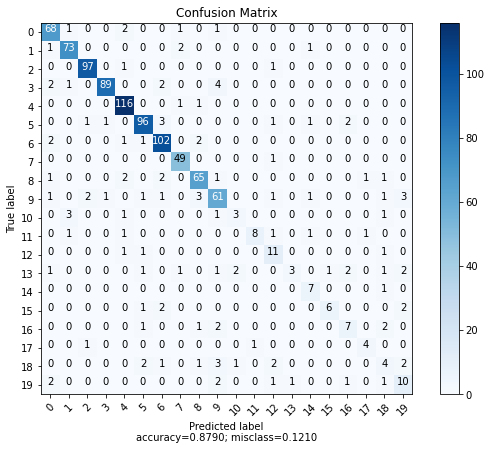

In [22]:
if (Testing_Percentage > 0):
    y_pred = model.predict(X_test)
    print('Accuracy: ' + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))))
    print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
    plot_confusion_matrix(cm=confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)), 
                      normalize    = False,
                      target_names = subdir,
                      title        = "Confusion Matrix",
                      file_name    = "testCF")
    

# Show model
The architecture of the model is illustrated.

In [24]:
model.export_model().summary()

from contextlib import redirect_stdout

with open('modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        model.export_model().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 20, 3)]       0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 32, 20, 3)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 20, 3)         7         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 18, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 16, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 8, 64)         0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 8, 64)         0     

# Save model
Saving the model to h5 format and tflite format.

In [47]:
model.export_model().save('watermetter_model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
flatbuffer_size = open('watermetter_model.tflite', "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\diego\AppData\Local\Temp\tmp42gio00p\assets


# Load and test tflite model
* Loading the tflite model.
* Testing the tflite model.

Accuracy: 0.6625766871165644
              precision    recall  f1-score   support

           0       0.62      0.71      0.67         7
           1       0.80      0.73      0.76        11
           2       0.44      0.33      0.38        12
           3       0.00      0.00      0.00         6
           4       0.25      0.14      0.18         7
           5       0.38      0.38      0.38         8
           6       0.62      0.38      0.48        13
           7       0.14      0.14      0.14         7
           8       0.25      0.38      0.30         8
           9       0.33      0.50      0.40         4
          10       0.85      0.95      0.90        80

    accuracy                           0.66       163
   macro avg       0.43      0.42      0.42       163
weighted avg       0.64      0.66      0.64       163



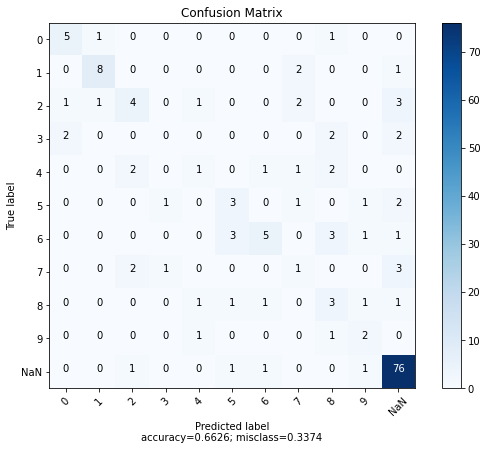

In [61]:
interpreter = tf.lite.Interpreter(model_path='watermetter_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
for i in range(0, len(X_test)):
    interpreter.set_tensor(input_details[0]['index'], [X_test[i]])
    interpreter.invoke()
    if i == 0:
        y_pred_lite = interpreter.get_tensor(output_details[0]['index'])
    else:
        y_pred_lite = np.append(y_pred_lite, interpreter.get_tensor(output_details[0]['index']), axis=0)

print('Accuracy: ' + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred_lite, axis=1))))
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_lite, axis=1)))
plot_confusion_matrix(cm=confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_lite, axis=1)), 
                      normalize    = False,
                      target_names = subdir,
                      title        = "Confusion Matrix",
                      file_name    = 'tfliteTestCF')

### Learing result
 
* Visualization of the training and validation results

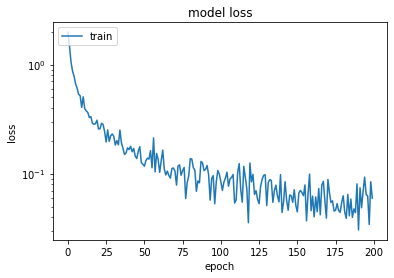

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


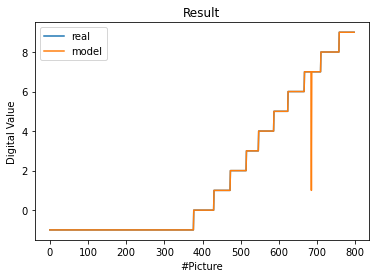

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = model.predict_classes(img)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = "Train_CNN_Digital-Readout_Version_" + Version
# model.save(FileName + ".h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

218936

In [8]:
FileName = "Train_CNN_Digital-Readout_Version_" + Version
# model.save(FileName + ".h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

218936

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


In [9]:
Input_dir='ziffer_sortiert_resize'
only_deviation = True

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = model.predict_classes(img)
        classes = classes[0]
        if classes == 10: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))


ziffer_sortiert_resize/7\D6_2020-08-19_21-15-56.jpg 7 1


Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.